## Bike demand predict

In [199]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

train = pd.read_csv("../input/bike-sharing-demand/train.csv")
test = pd.read_csv("../input/bike-sharing-demand/test.csv")

In [185]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [186]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [187]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [188]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


Range of variable in train and test is similar. So for now, i don't remove outlier

<br><br>

### Create variables and visualization
create columns from datetime

In [201]:
for df in [train, test]:
    df["datetime"] =  pd.DatetimeIndex(df["datetime"])
    df["hour"] = [x.hour for x in df["datetime"]]
    df["weekday"] = [x.dayofweek for x in df["datetime"]]
    df["month"] = [x.month for x in df["datetime"]]
    df["year"] = [x.year for x in df["datetime"]]
    df["year"] = df["year"].map({2011:1, 2012:0})
    df.drop('datetime',axis=1,inplace=True)

See variables's distribution by distplot and countplot

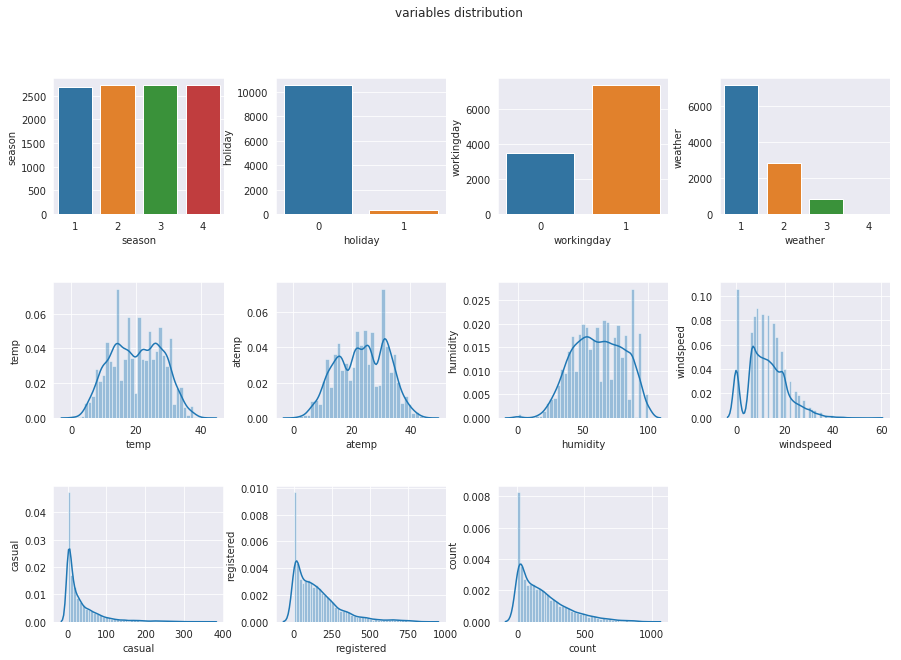

In [190]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,10))
plt.suptitle('variables distribution')
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
for i, col in enumerate(train.columns[:11]):
    plt.subplot(3,4,i+1)
    if str(train[col].dtypes)[:3]=='int':
        if len(train[col].unique()) > 5:
            sns.distplot(train[col])
        else:
            sns.countplot(train[col])
    else:
        sns.distplot(train[col])
    plt.ylabel(col)

see relation of categorical predictors and outcomes by countplot

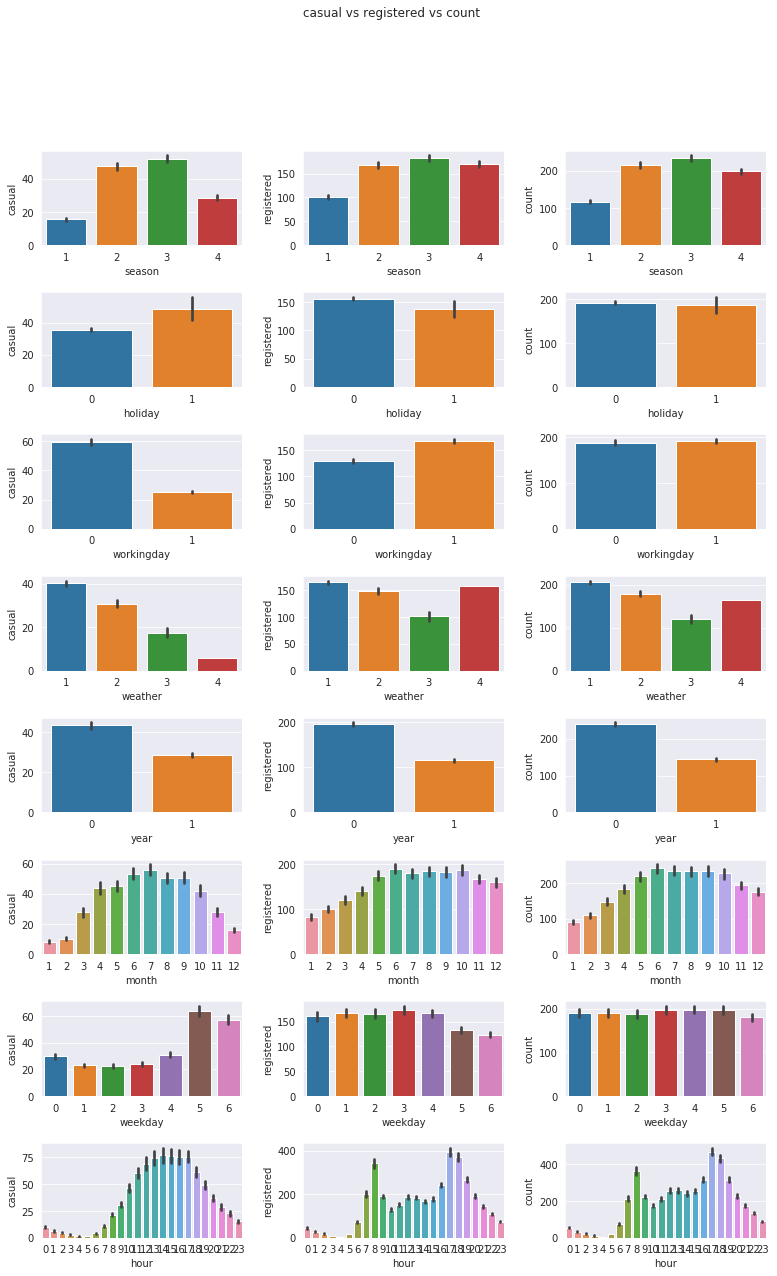

In [174]:
plt.figure(figsize=(13,20))
plt.suptitle('casual vs registered vs count')
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
col_list = ["season","holiday","workingday","weather","year","month","weekday","hour"]
count_list = ["casual","registered","count"]

for i, col in enumerate(col_list):
    for j, con in enumerate(count_list):
        plt.subplot(8,3,3*i+j+1)
        sns.barplot(train[col],train[con])

see relation of hour and casual by workingday and holiday

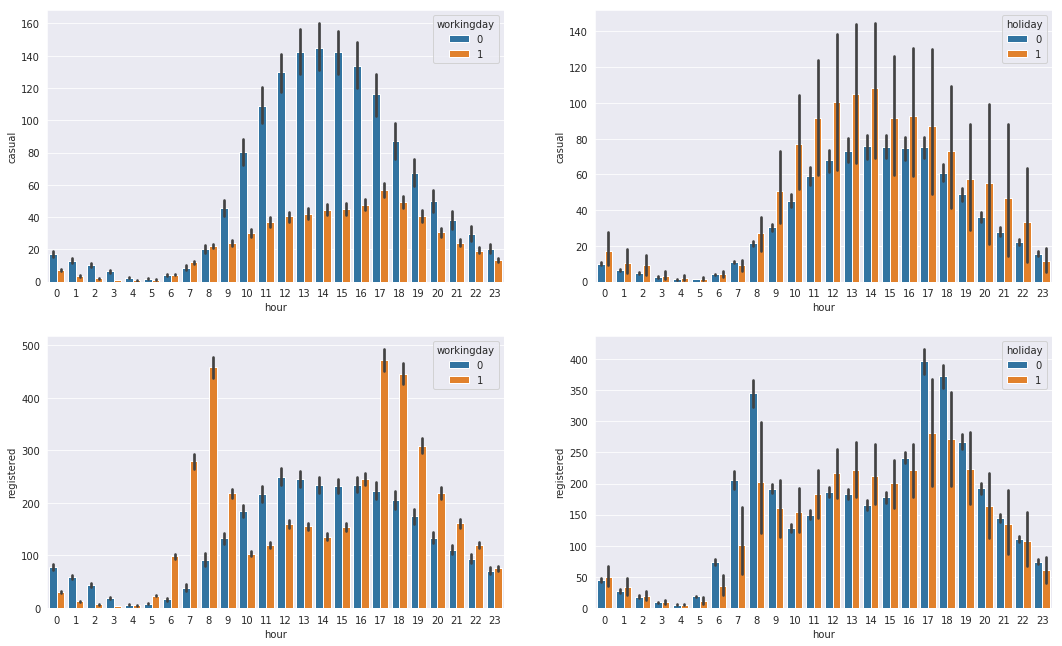

In [80]:
plt.figure(figsize=(18,11))
plt.subplot(221)
sns.barplot(x="hour", y="casual", hue="workingday", data=train)
plt.subplot(222)
sns.barplot(x="hour", y="casual", hue="holiday", data=train)
plt.subplot(223)
sns.barplot(x="hour", y="registered", hue="workingday", data=train)
plt.subplot(224)
sns.barplot(x="hour", y="registered", hue="holiday", data=train)
# train.pivot_table(index="hour", columns="workingday", aggfunc="size")

So registered is expected to be workers.

## correlation

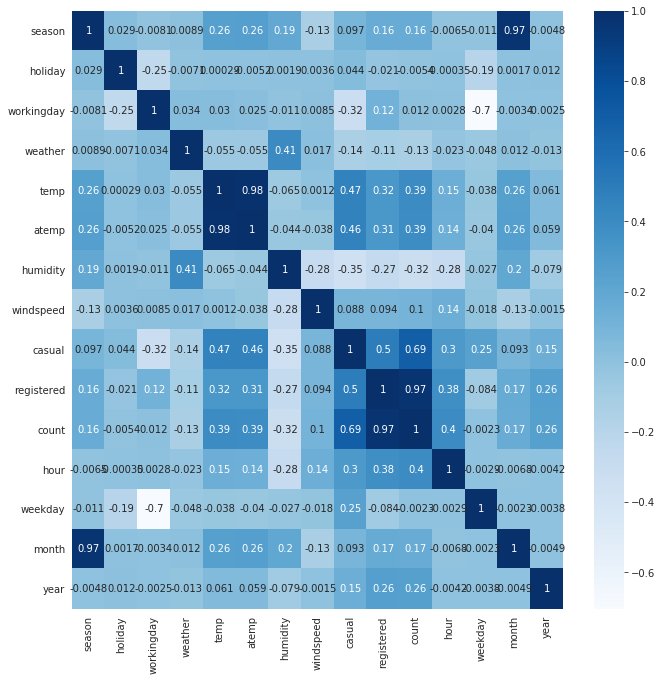

In [25]:
plt.figure(figsize=(11,11))
sns.heatmap(train.corr(),annot=True,cmap="Blues")

temp and atemp have high correlation and register and have too.
And windspeed and outcomes have low correlation(<=0.1)

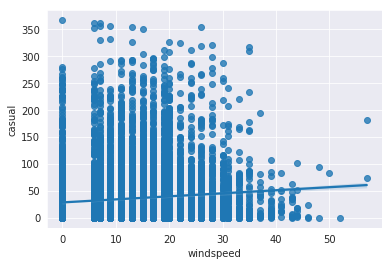

In [66]:
sns.regplot(x = 'windspeed', y = 'casual',data = train)

And verify categorical variables to dummy variables

In [202]:
df_list = {"train":None, "test" : None}
for name, df in zip(df_list.keys(),[train, test]):
    df['casual_workhour'] = df[['hour', 'workingday']].apply(lambda x: int(x['workingday'] == 0 and 10 <= x['hour'] <= 19), axis=1)
    df['casual_holi_hour'] = df[['hour', 'holiday']].apply(lambda x: int(x['holiday'] == 1 and 9 <= x['hour'] <= 22), axis=1)
    df['register_workhour'] = df[['hour', 'workingday']].apply(
      lambda x:int((x['workingday'] == 1 and (6 <= x['hour'] <= 8 or 17 <= x['hour'] <= 20))
        or (x['workingday'] == 0 and 10 <= x['hour'] <= 15)), axis=1)
    df['register_holi_hour'] = df[['hour', 'holiday']].apply(
      lambda x:int(x['holiday'] == 0 and (7 <= x['hour'] <= 8 or 17 <= x['hour'] <= 18)), axis=1)
    season = pd.get_dummies(df['season'],prefix='season')
    weather=pd.get_dummies(df['weather'],prefix='weather')
    weekday=pd.get_dummies(df['weekday'],prefix='weekday')
    month=pd.get_dummies(df['month'],prefix='month')
    hour =pd.get_dummies(df['hour'],prefix='hour')
    df.drop(["season","weather","hour","weekday","month","year","windspeed","atemp"],axis=1,inplace=True)
    df_list[name] = pd.concat([df,season,weather,weekday,month,hour],axis=1,sort=False)

In [204]:
train1 = df_list["train"]
test1 = df_list["test"]
del df_list

#### Divide predictors and outcomes. And take logging outcomes to normalize.

In [205]:
from sklearn.model_selection import train_test_split
y_list = ["casual","registered","count"]
train_x = train1[[col for col in train1.columns if col not in ['casual','registered', 'count']]]
train_y = np.log(train1[y_list]+1)
train_x.head()
# x_train, x_val, y_train, y_val = train_test_split(train_x,train_y, test_size=0.2, random_state=0)

,holiday,workingday,temp,humidity,casual_workhour,casual_holi_hour,register_workhour,register_holi_hour,daycode_01,daycode_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,0,9.84,81,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,9.02,80,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,9.02,80,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,9.84,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,9.84,75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modeling

Use lightgbm model, and use cross-validation to prevent overfitting

In [206]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

folds = KFold(n_splits = 5, shuffle = True, random_state = 123)
rms1,rms2 = [],[]
models1,models2 = [], []
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train1)) :
    x_train, y_train = train_x.ix[trn_idx], train_y.ix[trn_idx] 
    x_val, y_val = train_x.ix[val_idx], train_y.ix[val_idx]
    
    lgb_param = {'boosting_type':'gbdt',
             'num_leaves': 45,
             'max_depth': 30,
            'learning_rate': 0.01, 
            'bagging_fraction' : 0.9,
            'bagging_freq': 20,
            'colsample_bytree': 0.9,
             'metric': 'rmse',
            'min_child_weight': 1,
            'min_child_samples': 10,
             'zero_as_missing': True,
            'objective': 'regression',
            }
    train_set1 = lgb.Dataset(x_train, y_train["registered"], silent=False)
    valid_set1 = lgb.Dataset(x_val, y_val["registered"], silent=False)
    lgb_model1 = lgb.train(params = lgb_param, train_set = train_set1 , num_boost_round=5000, early_stopping_rounds=100,verbose_eval=500, valid_sets=valid_set1)
    train_set2 = lgb.Dataset(x_train, y_train["casual"], silent=False)
    valid_set2 = lgb.Dataset(x_val, y_val["casual"], silent=False)
    lgb_model2 = lgb.train(params = lgb_param, train_set = train_set2 , num_boost_round=5000, early_stopping_rounds=100,verbose_eval=500, valid_sets=valid_set2)
    pred1 = lgb_model1.predict(x_val)
    pred2 = lgb_model2.predict(x_val)
    rms1.append(mean_squared_error(pred1,y_val["registered"]))
    rms2.append(mean_squared_error(pred2,y_val["casual"]))
    models1.append(lgb_model1)
    models2.append(lgb_model2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.381428
[1000]	valid_0's rmse: 0.363836
[1500]	valid_0's rmse: 0.357521
[2000]	valid_0's rmse: 0.352641
Early stopping, best iteration is:
[2380]	valid_0's rmse: 0.350698
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.515717
[1000]	valid_0's rmse: 0.50294
[1500]	valid_0's rmse: 0.499977
[2000]	valid_0's rmse: 0.498438
Early stopping, best iteration is:
[2013]	valid_0's rmse: 0.498235


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.377594
[1000]	valid_0's rmse: 0.362013
[1500]	valid_0's rmse: 0.356273
[2000]	valid_0's rmse: 0.351296
[2500]	valid_0's rmse: 0.348784
Early stopping, best iteration is:
[2660]	valid_0's rmse: 0.347904
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.533702
[1000]	valid_0's rmse: 0.517159
[1500]	valid_0's rmse: 0.512019
[2000]	valid_0's rmse: 0.510225
Early stopping, best iteration is:
[1997]	valid_0's rmse: 0.510214


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.397795
[1000]	valid_0's rmse: 0.379376
[1500]	valid_0's rmse: 0.372342
[2000]	valid_0's rmse: 0.366941
[2500]	valid_0's rmse: 0.364503
[3000]	valid_0's rmse: 0.362493
Early stopping, best iteration is:
[3280]	valid_0's rmse: 0.361542
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.506666
[1000]	valid_0's rmse: 0.489489
[1500]	valid_0's rmse: 0.485808
Early stopping, best iteration is:
[1497]	valid_0's rmse: 0.485803


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.366079
[1000]	valid_0's rmse: 0.350349
[1500]	valid_0's rmse: 0.345125
[2000]	valid_0's rmse: 0.342538
[2500]	valid_0's rmse: 0.340667
Early stopping, best iteration is:
[2459]	valid_0's rmse: 0.340352
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.517862
[1000]	valid_0's rmse: 0.499039
[1500]	valid_0's rmse: 0.493594
Early stopping, best iteration is:
[1741]	valid_0's rmse: 0.491442


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.383934
[1000]	valid_0's rmse: 0.368693
[1500]	valid_0's rmse: 0.363038
[2000]	valid_0's rmse: 0.358328
[2500]	valid_0's rmse: 0.355729
[3000]	valid_0's rmse: 0.353736
Early stopping, best iteration is:
[3397]	valid_0's rmse: 0.352454
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.51395
[1000]	valid_0's rmse: 0.497844
[1500]	valid_0's rmse: 0.495536
Early stopping, best iteration is:
[1480]	valid_0's rmse: 0.49518


In [207]:
print(rms1)
print(rms2)

[0.12298902420776557, 0.12103752673122682, 0.13071233434075705, 0.11583937610042899, 0.1242236241975193]
[0.2482384633159906, 0.26031856248786744, 0.23600455765654238, 0.24151506154040805, 0.2452033971666616]


[Text(0, 0, 'humidity'),
 Text(0, 0, 'temp'),
 Text(0, 0, 'workingday'),
 Text(0, 0, 'weather_1'),
 Text(0, 0, 'weekday_4'),
 Text(0, 0, 'weekday_2'),
 Text(0, 0, 'weekday_0'),
 Text(0, 0, 'weekday_6'),
 Text(0, 0, 'weather_2'),
 Text(0, 0, 'weekday_1'),
 Text(0, 0, 'season_1'),
 Text(0, 0, 'register_workhour'),
 Text(0, 0, 'season_4'),
 Text(0, 0, 'weekday_5'),
 Text(0, 0, 'weather_3'),
 Text(0, 0, 'weekday_3'),
 Text(0, 0, 'casual_workhour'),
 Text(0, 0, 'month_1'),
 Text(0, 0, 'season_2'),
 Text(0, 0, 'month_2'),
 Text(0, 0, 'month_3'),
 Text(0, 0, 'hour_6'),
 Text(0, 0, 'month_4'),
 Text(0, 0, 'month_12'),
 Text(0, 0, 'register_holi_hour'),
 Text(0, 0, 'hour_3'),
 Text(0, 0, 'hour_23'),
 Text(0, 0, 'hour_5'),
 Text(0, 0, 'holiday'),
 Text(0, 0, 'hour_1'),
 Text(0, 0, 'hour_0'),
 Text(0, 0, 'hour_2'),
 Text(0, 0, 'hour_4'),
 Text(0, 0, 'hour_7'),
 Text(0, 0, 'hour_9'),
 Text(0, 0, 'month_10'),
 Text(0, 0, 'month_5'),
 Text(0, 0, 'month_9'),
 Text(0, 0, 'month_11'),
 Text(0, 0, 'mont

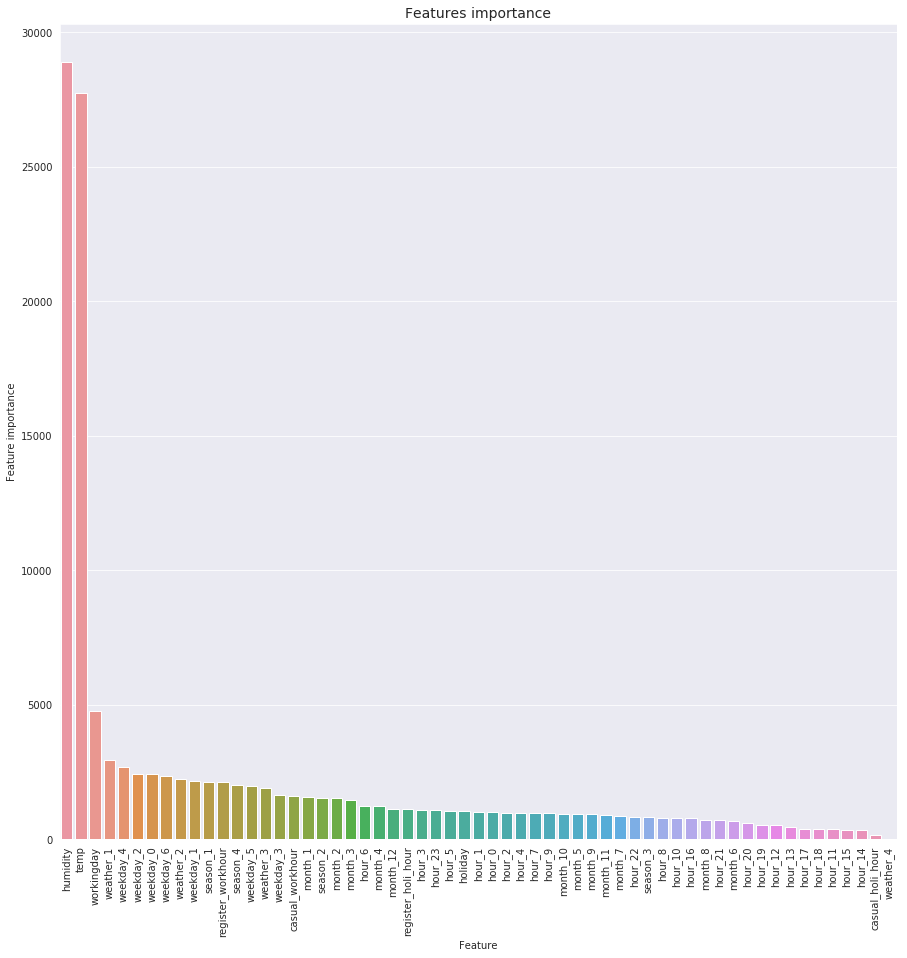

In [180]:
tmp = pd.DataFrame({'Feature': x_train.columns, 'Feature importance': lgb_model1.feature_importance()})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [209]:
preds = []
for model in models1:
    casual_pred = model.predict(test1)
    preds.append(casual_pred)
fin_casual = np.mean(preds, axis=0)

preds = []
for model in models2:
    regi_pred = model.predict(test1)
    preds.append(regi_pred)
fin_regi = np.mean(preds, axis=0)
count_pred = np.exp(fin_casual) + np.exp(fin_regi) - 2

sample = pd.read_csv("../input/bike-sharing-demand/sampleSubmission.csv")
sample["count"] = count_pred
sample.to_csv("sample.csv",index=False)

In [210]:
sample.head()

,datetime,count
0,2011-01-20 00:00:00,19.744004
1,2011-01-20 01:00:00,6.429274
2,2011-01-20 02:00:00,4.827070
3,2011-01-20 03:00:00,3.791149
4,2011-01-20 04:00:00,2.439540


In [122]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
preds = {}
regs = {"gbdt": GradientBoostingRegressor(random_state=0),
        "rf": RandomForestRegressor(random_state=0, n_jobs=-1)}
for name, reg in regs.items():
    if name == 'gbdt':
        reg.set_params(n_estimators=1000, min_samples_leaf=6)
    elif name == 'rf':
        reg.set_params(n_estimators=1000, min_samples_leaf=2)
    reg.fit(train_x, train_y['casual'])
    pred_casual = reg.predict(test)
    pred_casual = np.exp(pred_casual) - 1
    pred_casual[pred_casual < 0] = 0
    if name == 'gbdt':
        reg.set_params(n_estimators=1000, min_samples_leaf=6)
    elif name == 'rf':
        reg.set_params(n_estimators=1000, min_samples_leaf=2)
    reg.fit(train_x, train_y['registered'])
    pred_registered = reg.predict(test)
    pred_registered = np.exp(pred_registered) - 1
    pred_registered[pred_registered < 0] = 0
    preds[name] = pred_casual + pred_registered

In [124]:
reg.feature_importances_

array([0.00676322, 0.0009844 , 0.02199951, 0.01005461, 0.00927827,
       0.00961986, 0.01336082, 0.00652332, 0.69214133, 0.02573351,
       0.04883903, 0.04009739, 0.0018726 , 0.02766187, 0.07465079,
       0.01041947])

array([ 10.95794745,   4.98893712,   2.75027649, ..., 164.53764869,
       107.77544599,  59.68775311])

In [ ]:
count_pred = np.exp(fin_casual) + np.exp(fin_regi)-2
sns.regplot(np.exp(y_val["count"])-1, count_pred, x_bins = 200)

In [ ]:
preds = []
for model in models1:
    casual_pred = model.predict(test1)
    preds.append(casual_pred)
fin_casual = np.mean(preds, axis=0)
preds
# preds = []
# for model in models2:
#     regi_pred = model.predict(test1)
#     preds.append(regi_pred)
# fin_regi = np.mean(preds, axis=0)
# count_pred = np.exp(fin_casual) + np.exp(fin_regi)-2

In [ ]:
pd.Series(count_pred).describe()

In [ ]:
sample = pd.read_csv("../input/bike-sharing-demand/sampleSubmission.csv")
sample["count"] = count_pred
sample.to_csv("sample.csv",index=False)

In [ ]:
sample.head()

In [9]:
by_season

,count_season
year_season,
2011.1,57
2011.2,136
2011.3,163
2011.4,128
2012.1,120
2012.2,239
2012.3,251
2012.4,211
